<a href="https://colab.research.google.com/github/Debottam/Autoencoder/blob/master/tripletVAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import check_random_state
print("tf version: ", tf.__version__)
print("keras version: ", keras.__version__)

tf version:  2.3.0
keras version:  2.4.0


In [2]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_1 = [x_train[i] for i in range(len(y_train)) if y_train[i]==1]
x_1 = np.array(x_1)
x_1.shape

(6742, 784)

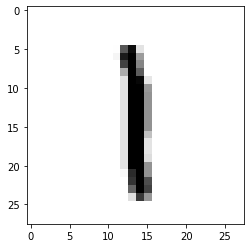

In [4]:
plt.imshow(x_1[3].reshape(28, 28), cmap=plt.cm.binary)

In [5]:
x_2 = [x_train[i] for i in range(len(y_train)) if y_train[i]==8]
x_2 = np.array(x_2)

In [6]:
x_2.shape

(5851, 784)

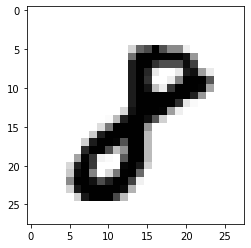

In [7]:
plt.imshow(x_2[1].reshape(28, 28), cmap=plt.cm.binary)

In [8]:
x_1_pr = x_1/255.
x_2_pr = x_2/255.

In [10]:
# mixing x_1 and x_2 samples
mixed_train = np.concatenate((x_1,x_2), axis = 0)
y = np.concatenate((np.zeros((len(x_1))),np.ones((len(x_2)))), axis=0)
rng = check_random_state(1)
indices_1 = rng.permutation(len(mixed_train))
mixed_train_rnd = mixed_train[indices_1]
y_rnd = y[indices_1]
print("mixed_train_rnd: ",mixed_train_rnd.shape)
print("y_rnd: ",y_rnd.shape)

mixed_train_rnd:  (12593, 784)
y_rnd:  (12593,)


In [11]:
bkg_index = np.where(y_rnd==0)[0]
def create_batch(batch_size=64):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0,batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.choice(bkg_index)
        x_anchor = mixed_train_rnd[random_index]
        y = y_rnd[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_rnd == y))
        indices_for_neg = np.squeeze(np.where(y_rnd != y))
        
        x_positive = mixed_train_rnd[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = mixed_train_rnd[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [12]:
x, y, z = create_batch(2)

In [13]:
x.shape

(2, 784)

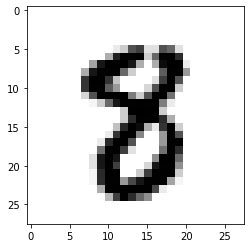

In [14]:
plt.imshow((z[0].reshape(28, 28))*255., cmap=plt.cm.binary)

In [51]:
# kl_loss
def kl_reconstruction_loss(x, recon_x, mu, log_var):
    #reco_loss = tf.reduce_mean(tf.square(x - recon_x))
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(kl_loss)

# triplet loss
def triplet_loss(anchor, positive, negative):
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [52]:
input_dim = 784
encoding_dim = 10
inputs = keras.Input((None, input_dim))

class _Encoder(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.layer_1 = keras.layers.Dense(256, activation="relu")
        self.layer_2 = keras.layers.Dense(128, activation="relu")
        self.layer_3 = keras.layers.Dense(64, activation="relu")

    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = keras.layers.Dense(encoding_dim, name="z_mean")(x)
        self.log_var = keras.layers.Dense(encoding_dim, name="z_log_var")(x)
        self.z = keras.layers.Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.z, self.mean, self.log_var

class _Decoder(keras.Model):
    def __init__(self):
        super(self).__init__()
        self.layer_1 = keras.layers.Dense(128, activation="relu")
        self.layer_2 = keras.layers.Dense(256, activation="relu")
        self.layer_3 = keras.layers.Dense(784, activation="sigmoid")
        
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        output = self.layer_3(x)
        return output